# Logit Response Dynamics

**Yuya Furusawa**

*Graduate School of Economics, University of Tokyo*

This notebook demonstrates how to study logit best response dynamics model using the `logitdyn` Python library.

In [1]:
import numpy as np
import quantecon.game_theory as gt
import matplotlib.pyplot as plt

## Logit Response Dynamics

Logit response dynamics model is one of the learning models.
There is much literature that studies the learning in games, for example, fictitious play, (myopic) best response dynamics, Kandori-Mailath-Rob, sampling best response models.
Please refer these notes:
- fictitious play
- best response dynamics

The learning model with random mistakes, including KMR model, is criticised by the absense of the foundation of mistakes.

In contrast, **Logit response dynamics**, which incorporates the random mistakes, is based on a theory about the origin of mistakes.

### Model

Let $\Gamma = (I, {(S_i, u_i)}_{i \in I})$ be a finite normal form game.
- $I=\{1,\ldots,N\}$ : player set
- $S_i$ : strategies set ($S$ : pure strategy profile)
- $u_i$ : payoff function

Denote $s=(s_i, s_{-i}) \in S$ and $u_i(s_i, s_{-i})=u_i(s)$.

In logit response dynamics model, players behave as myopic best replier, but have mistakes in thier decisions.
A player is chosen to update her action given other players' actions every period (**asynchronous learning**).

When player $i$ is chosen, she will update her action to $s_i$ given actions $s_{-i}$.
The probability of choosing action $s_i$ is given by **logit choice function** :
$$
    p_i(s_i, s_{-i}) = \frac{\exp(\beta u_i(s_i, s_{-i}))}{\sum_{s_i' \in S_i} \exp(\beta u_i(s_i', s_{-i}))}
$$
where $0 < \beta < \infty$.

$\beta$ can be interpreted as an inverse measure of the level of noise in players' decisions.
As $\beta$ becomes larger, the size of noise becomes smaller.
From the microeconomic point of view, this modeling is based on a random-utility model, decision thoretic foundation.

Logit response dynamics can converge to the set of Nash equilibria in the potential game.
We call this converged state as stabel state.
First, we introduce the definition of potential game.

**Definition(potential game)**

The $\Gamma$ is a *potential game* if there exists a function $\rho:S \rightarrow \mathbb{R}$ such that for all $i \in I$, $s_i, s_i' \in S_i$, $s_{-i} \in S_{-i}$,
$$
    u_i(s_i, s_{-i}) - u_i(s_i', s_{-i}) = \rho(s_i, s_{-i}) - \rho(s_i', s_{-i})
$$

$\rho$ is called the potential.

The following game is the potential game:

1$\backslash$2 | $A$           | $B$ 
 ------------- |---------------| ---------
 $A$           | 4, 4          |   0, 3   
 $B$           | 3, 0          |   2, 2     
 
To see this, the potential $\rho$ can be defined

1$\backslash$2 | $A$        | $B$ 
 ------------- |------------| ---------
 $A$           | 1          |   0  
 $B$           | 0          |   2     

(Note every $2 \times 2$ symmetric game is the potential game)

**Theorem**

In the potential game, the set of stable states of logit response dynamics is equal to the set of maximizers of $\rho$.

We will check this later.

## `logitdyn.py` usage

To create `LogitDynamics` class instance, you need the played game and the parameter $\beta$.
The game has to be `NormalFormGame` instance or array like.
As argued before, $\beta$ is the level of noise in the players' decisions.

In [2]:
payoff = [[4, 0],
          [3, 2]]
game = gt.NormalFormGame(payoff)
beta = 2.0
ldy = gt.LogitDynamics(game, beta)

You can check the cumulative elements of logit choice function(normalized $\exp(\beta u_i(s_i, s_{-i}))$) for each player by `logit_choice_cdfs` method.

In [3]:
ldy.logit_choice_cdfs()

(array([[1.        , 1.13533528],
        [0.01831564, 1.01831564]]),
 array([[1.        , 1.13533528],
        [0.01831564, 1.01831564]]))

### `play` method

`play` method returns a new action profile in the model.
You can specify the initial action profile.
If not provided, it is determined randomly.
In addition, you can proceed the dynamics multiple times by specifying `num_reps`, which is set to 1 by default.

In [4]:
init_actions = (0, 0) # both players take action 0
ldy.play(init_actions)

(0, 0)

In [5]:
ldy.play(init_actions, num_reps=3)

(1, 1)

### `time_series` method

`time_series` method returns a time series of action distributions.
You have to specify the length of time series.
In addition, you can choose initial action distribution from which the dynamics proceeds.
If not specified, it is randomly choosed.

In [6]:
ts_length = 5
init_actions = (0, 0)
ldy.time_series(ts_length, init_actions)

array([[0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0]])

## Example

We see the convergence of the logit response dynamics in the potential game.
We use the coordination game defined above.

In [7]:
payoff = [[4,0],
          [3,2]]
beta = 4.0
ldy = gt.LogitDynamics(payoff, beta)

In [8]:
ts_length = 1000
init_actions = (0,0)
series = ldy.time_series(ts_length, init_actions)
seriesB = np.where(series==1, 1, 0)

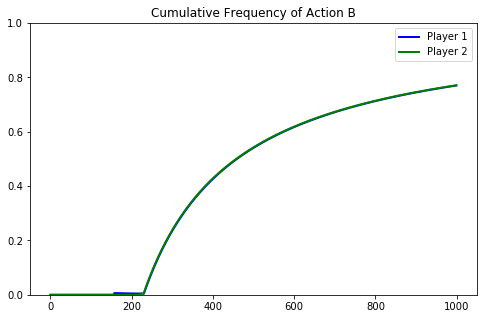

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_prop_cycle('color', ['b', 'g'])
ax.plot(np.cumsum(seriesB[:, 0], axis=0)/np.arange(1,ts_length+1), linewidth=2, label="Player 1")
ax.plot(np.cumsum(seriesB[:, 1], axis=0)/np.arange(1,ts_length+1), linewidth=2, label="Player 2")
ax.set_ylim(0, 1)
plt.legend()
plt.title("Cumulative Frequency of Action B")
plt.show()

As you can see, (B,B) is a stable state of this dynamics, and this state maximizers of the potential $\rho$.

Next, we simulate the logit reponse dynamics in the Young's game.
Young's game is defined as follows:

1$\backslash$2 | $A$           | $B$      | $C$
 ------------- |---------------| ---------| --------
 $A$           | 6, 6          |   0, 0   |   0, 0
 $B$           | 5, 5          |   7, 7   |   5, 5
 $C$           | 0, 0          |   5, 5   |   8, 8

In [10]:
young_game_matrix = [[6, 0, 0],
                     [5, 7, 5],
                     [0, 5, 8]]
beta = 4.0
ldy = gt.LogitDynamics(young_game_matrix, beta)

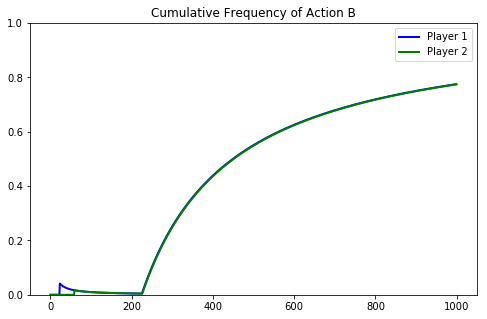

In [11]:
ts_length = 1000
init_actions = (0,0)
series = ldy.time_series(ts_length, init_actions)
seriesB = np.where(series==1, 1, 0)
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_prop_cycle('color', ['b', 'g'])
ax.plot(np.cumsum(seriesB[:, 0], axis=0)/np.arange(1,ts_length+1), linewidth=2, label="Player 1")
ax.plot(np.cumsum(seriesB[:, 1], axis=0)/np.arange(1,ts_length+1), linewidth=2, label="Player 2")
ax.set_ylim(0, 1)
plt.legend()
plt.title("Cumulative Frequency of Action B")
plt.show()

---

## Reference
- Alós-Ferrer, Carlos, and Nick Netzer. "The logit-response dynamics." Games and Economic Behavior 68.2 (2010): 413-427.